# Base-line

This the baseline of the project.

A Random Forest model is implemented, which loads a dataset and applies StandardScaler transformation to all numerical fields, also applies 70-30 partition for train and test sets respectively, achieving a final accuracy around 85%, and cross validation accuracy around 82%.

# Scope

The expected scope of this project is implementation of techniques and good practices to achieve deployment of the full functionality of this code through REST API.

# Situation

This is an excersice taken from kaggle to work with, in which the objective is to try to determine the median value of owner-occupied homes in $1000's [k\$] (**MEDV**, dependent variable), given a serie of independent variables like structural, neighborhood, accessibility and air pollution data in Boston around 70's.

To know more about the dataset you can see directly kaggle [link](https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data).

# Notebook

The following code in this notebook was tacken from several notebooks developed by other users in kaggle platform.

* [MAGANTI IT](https://www.kaggle.com/code/magantiit/linearregression)
* [SADIK AL JARIF](https://www.kaggle.com/code/sadikaljarif/boston-housing-price-prediction) 

In [1]:
#Imports
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

Follow instructions on this [link](https://www.geeksforgeeks.org/how-to-download-kaggle-datasets-into-jupyter-notebook/)

In [57]:
import opendatasets as od
kaggle_url = "https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data" 
od.download(kaggle_url, force=True)

#Finds the recently downloaded file
import os
from pathlib import Path
local_path = kaggle_url.split('/')[-1]
paths = sorted(Path(local_path).iterdir(), key=os.path.getmtime)
new_file_path = paths[-1]
new_file_name = str(new_file_path).split('\\')[-1]

#If recently downloaded file already exists in root, delete it
if os.path.isfile(new_file_path):
    print("Dataset downloaded!")
else:
    print("Something went wrong, dataset not downloades!")

#Moves the file to root instead of downloaded folder
import shutil
if os.path.isfile(new_file_name):
    os.remove(new_file_name)
os.rename(new_file_path, new_file_name)
print("And realocated successfully!")
shutil.rmtree(local_path)

100%|██████████| 12.3k/12.3k [00:00<00:00, 504kB/s]


Dataset downloaded!
And realocated successfully!


In [32]:
#Load dataset
raw_df = pd.read_csv('boston.csv', delimiter = ",")
print(raw_df.shape)
raw_df.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [33]:
numeric_columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT','MEDV']
pair_plot_columns = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT','MEDV']

In [34]:
#Check for nulls
raw_df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [35]:
corr=raw_df.corr()
corr.shape

(14, 14)

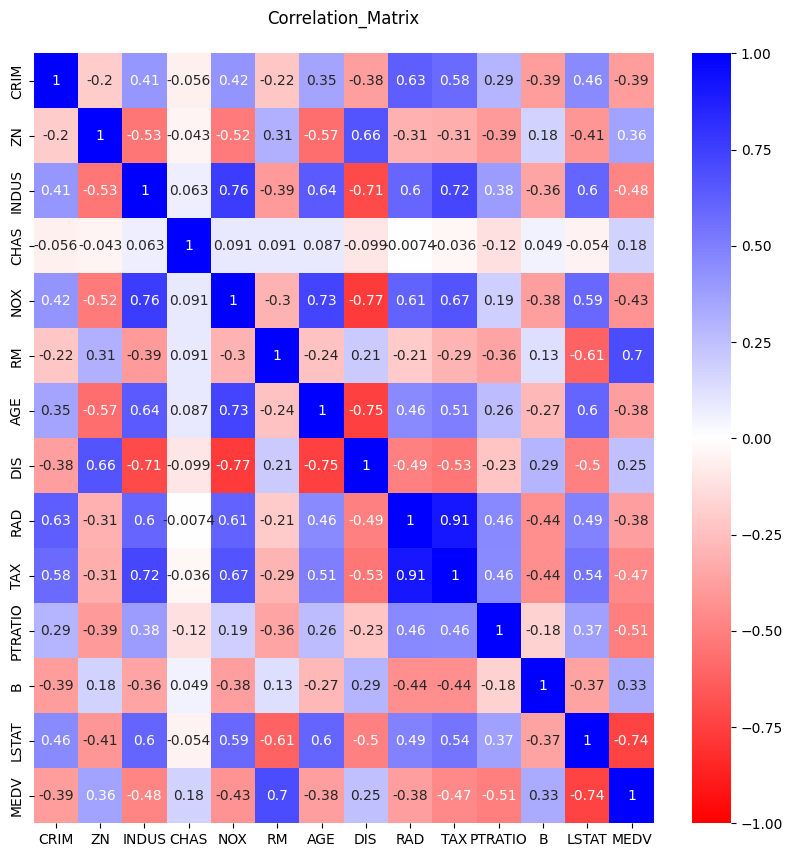

In [36]:
plt.figure(figsize=(10,10))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='bwr_r')
plt.title("Correlation_Matrix\n",color="black",fontsize=12)
plt.show()

Independent variables mor correlated to MDEV are RM (+0.7) and LSTAT (-0.74)

In [37]:
# Checking for distributions
def dist_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols,figsize=(16,16))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.kdeplot(dataset[data], ax=axs[i], fill=True,  alpha=.5, linewidth=0)
        axs[i].set_title(data + ', skewness is '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

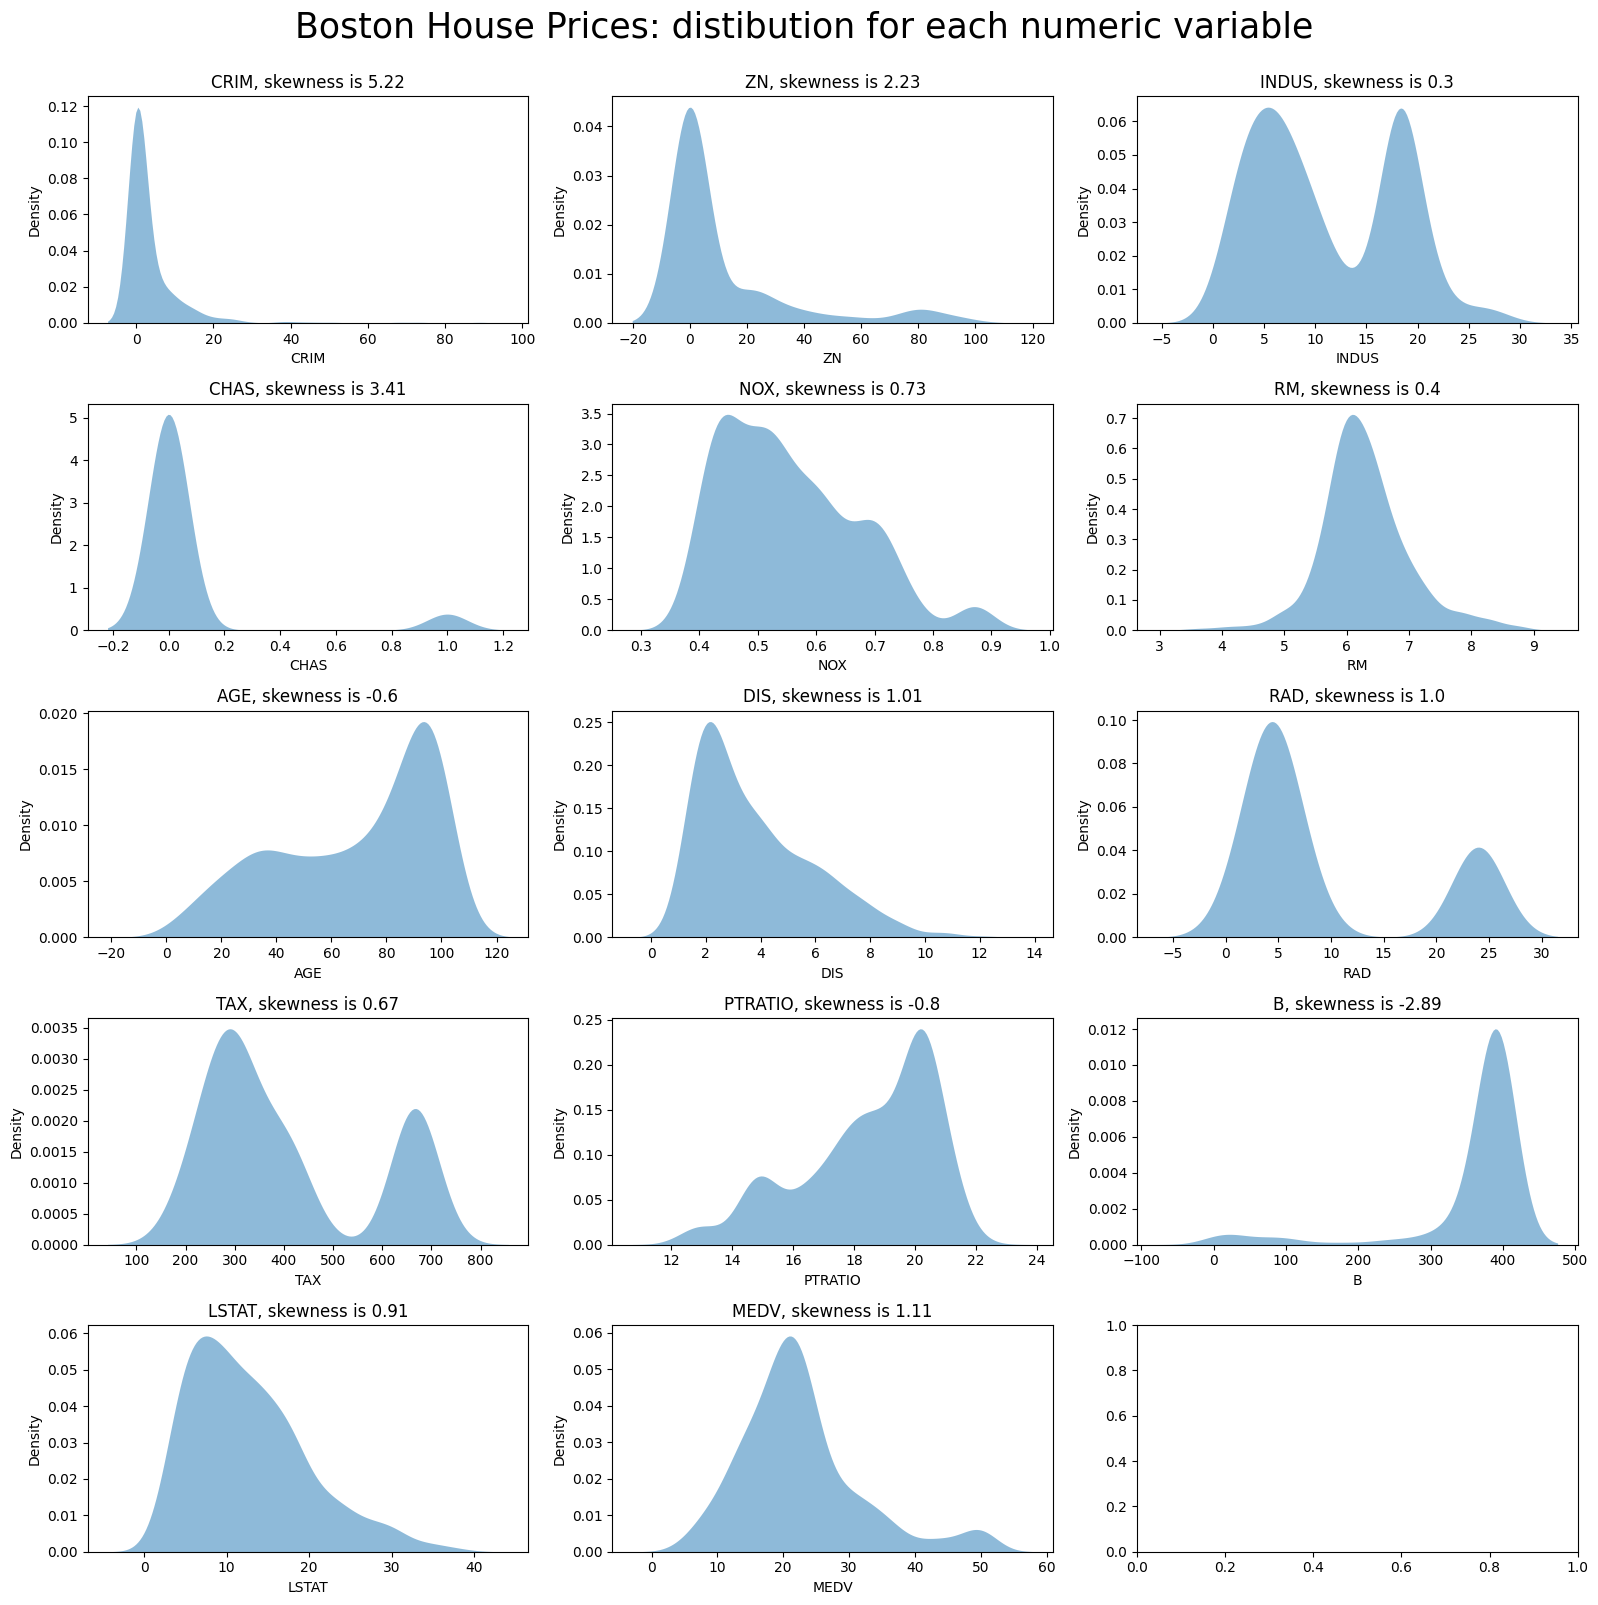

In [38]:
dist_custom(dataset=raw_df, columns_list=numeric_columns, rows=5, cols=3, suptitle='Boston House Prices: distibution for each numeric variable')
plt.tight_layout()

c:\Users\usuario\Documents\GitHub\mlops_project\venv_mlp\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1500 with 0 Axes>

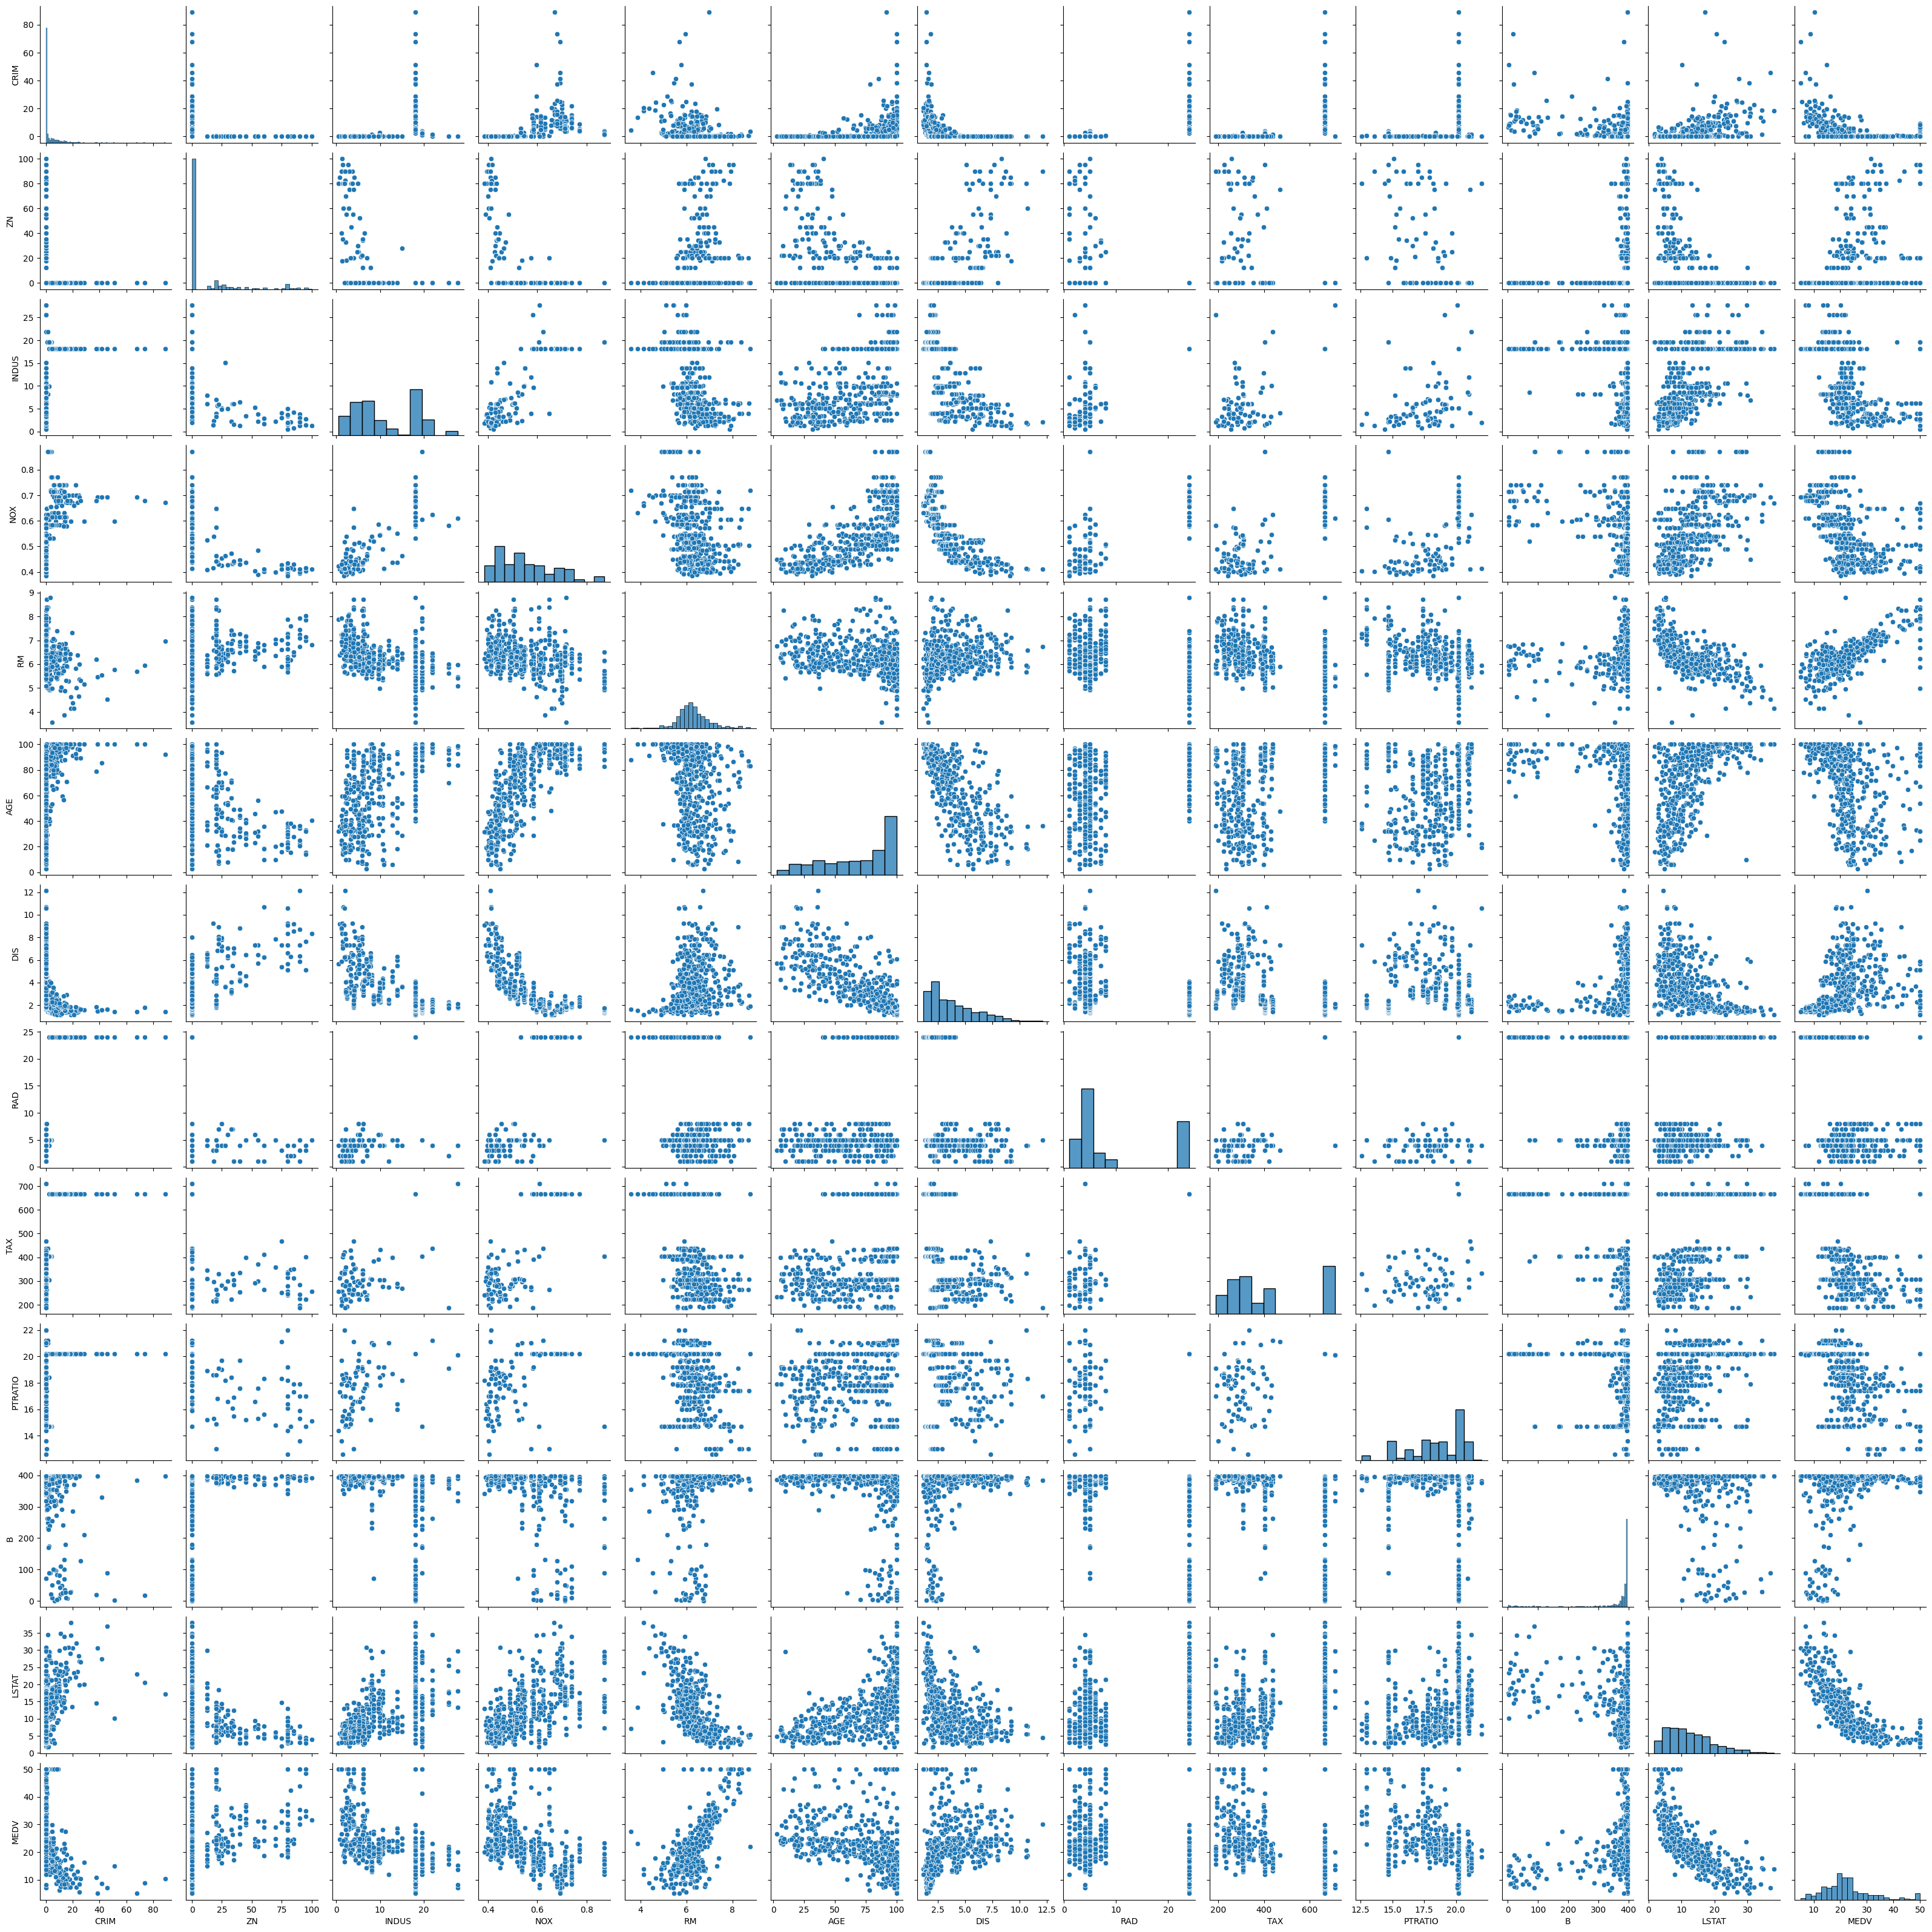

In [39]:
plt.figure(figsize=(15,15))
sns.pairplot(raw_df[pair_plot_columns])

plt.show()

In [40]:
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
                
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] < Q1 - outlier_step]
    df2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers:', df1.shape[0]+df2.shape[0])
    
    return multiple_outliers

In [41]:
Outliers_IQR = IQR_method(raw_df,1,numeric_columns)
# dropping outliers
df_clean = raw_df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers: 40


In [42]:
print(raw_df.shape)
print(df_clean.shape)

(506, 14)
(419, 14)


In [43]:
# Defines lists of variables independents and dependent
X = df_clean.iloc[:, :-1]
y = df_clean.iloc[:, -1]

In [44]:
# Data partition: train & test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [45]:
from sklearn.preprocessing import StandardScaler

# Creating function for scaling
def Standard_Scaler (df):
    #features = df[col_names]
    scaler = StandardScaler().fit(df)
    features = scaler.transform(df)
    df = features
    
    return df

In [46]:
X_train2 = Standard_Scaler (X_train)
X_test2 = Standard_Scaler (X_test)

In [47]:
from sklearn.ensemble import RandomForestRegressor

# Creating and training model
RandomForest_reg = RandomForestRegressor(n_estimators = 10, random_state = 0)

In [48]:
RandomForest_reg.fit(X_train, y_train)
# Model making a prediction on test data
y_pred = RandomForest_reg.predict(X_test)

In [49]:
cv_score = cross_val_score(estimator = RandomForest_reg, X = X_train, y = y_train, cv = 10)

# Calculating Adjusted R-squared
r2 = RandomForest_reg.score(X_test, y_test)
# Number of observations is the shape along axis 0
n = X_test.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = X_test.shape[1]
# Adjusted R-squared formula
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2 = RandomForest_reg.score(X_test, y_test)
CV_R2 = cv_score.mean()

print('R2:', round(R2,4))
print('Adjusted R2:', round(adjusted_r2, 4) )
print("Cross Validated R2: ", round(cv_score.mean(),4) )
print('RMSE:', round(RMSE,4))

R2: 0.8021
Adjusted R2: 0.7792
Cross Validated R2:  0.7303
RMSE: 2.7832


In [50]:
new_data_pred=np.array([[0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33]])

In [51]:
RandomForest_reg.predict(new_data_pred)

c:\Users\usuario\Documents\GitHub\mlops_project\venv_mlp\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([35.66])

In [52]:
new_data=np.array([[0.02729,0.0	,7.07,0	,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03]])
RandomForest_reg.predict(new_data)

c:\Users\usuario\Documents\GitHub\mlops_project\venv_mlp\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([36.06])

In [53]:
new_data = X_test.head()
print(RandomForest_reg.predict(new_data))
print(y_test.head())

[25.11 20.09 33.95 15.98 13.39]
203    27.5
278    19.8
172    37.9
368    14.1
352    14.5
Name: MEDV, dtype: float64
